In [139]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import naka_rushton_analysis as nra
import nub_utils
import sim_utils
import scipy.optimize as sop
from autograd import grad
import pdb
%matplotlib notebook

In [7]:
theta_pc = np.array([6.34298271e-03, 5.69163087e-01, 9.18911342e+01, 0.00000000e+00,
       0.00000000e+00, 1.07136027e+02, 0.00000000e+00, 7.11746462e+00,
       6.00000000e+01, 1.03761080e+01, 6.00000000e+01, 1.13089411e+00,
       1.53729545e+00, 1.00000000e+00, 0.00000000e+00])
theta_sst = np.array([  0.43845449,   0.        , 100.1285816 ,   0.        ,
         0.        ,  99.87192429,   0.        ,   8.32069014,
        60.        ,  11.54599245,  60.        ,   2.01347367,
         3.30632371,   1.        ,   0.        ])

In [24]:
c,d = np.linspace(0,100,101)/100,np.array((5,8,13,22,36,60))

In [31]:
pc_modeled = nub_utils.ayaz_model_div_ind_n_offset(c,d,*theta_pc)
sst_modeled = nub_utils.ayaz_model_div_ind_n_offset(c,d,*theta_sst)

<IPython.core.display.Javascript object>


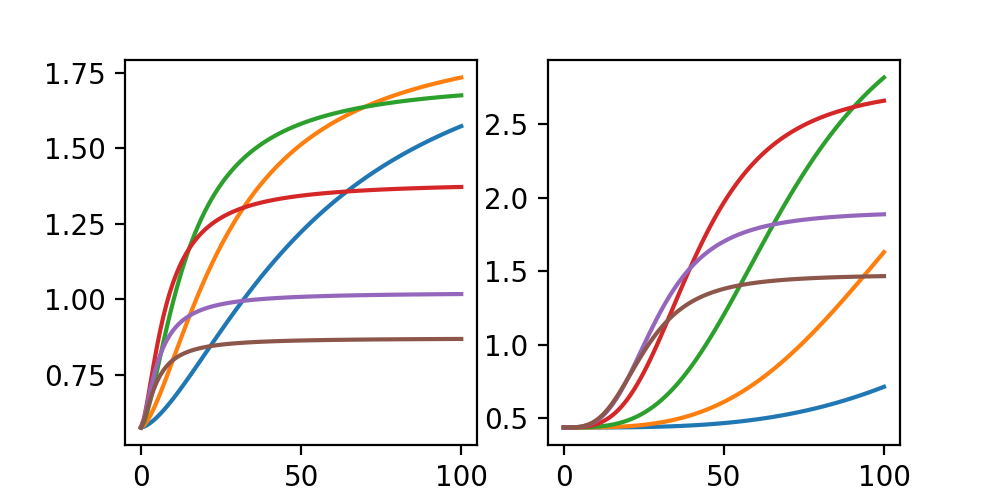

In [34]:
plt.figure(figsize=(5,2.5))
plt.subplot(1,2,1)
plt.plot(pc_modeled.T)
plt.subplot(1,2,2)
plt.plot(sst_modeled.T)

<IPython.core.display.Javascript object>


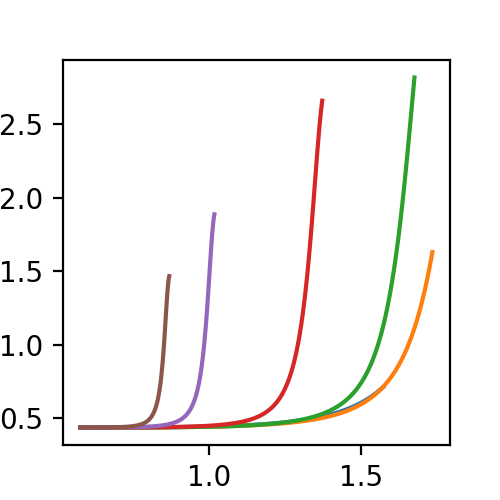

In [43]:
plt.figure(figsize=(2.5,2.5))
for isize in range(6):
    plt.plot(pc_modeled[isize],sst_modeled[isize])
# plt.plot(sst_modeled[isize])

In [49]:
f_ = lambda x: sim_utils.f_miller_troyer(x,1)
fp_ = lambda x: sim_utils.fprime_miller_troyer(x,1)

In [75]:
def compute_recurrent_soln(b0e,b0i,wie,wei,h):
    def cost(re,ri):
        return (re - f_(h+b0e-wei*ri))**2 + (ri - f_(b0i+wie*re))**2
    def cost_(theta):
        return cost(*theta)
    def costp_(theta):
        return grad(cost_)(theta)
    theta0 = np.zeros((2,))
    bds = sop.Bounds(lb=np.zeros((2,)),ub=np.inf*np.ones((2,)))
    res = sop.minimize(cost_,theta0,jac=costp_,bounds=bds,method='L-BFGS-B')
    re0,ri0 = res.x
    return re0,ri0

In [83]:
compute_recurrent_soln(0,-1,1,1,0.)

(0.3284682156907396, 0.14989502286488787)

In [78]:
cost_(np.array((0.19632744190806914, 0.5047708011940482)))

2.1136245949781557e-12

In [91]:
def compute_recurrent_solns(b0e,b0i,wie,wei,hmax=1,nh=101):
    hs = np.linspace(0,hmax,nh)
    re0,ri0 = compute_recurrent_soln(b0e,b0i,wie,wei,hs[0])
    dh = hs[1] - hs[0]
    re,ri = [np.zeros((nh,)) for _ in range(2)]
    for ih,h in enumerate(hs[:-1]):
        xe = h + b0e - wei*ri[ih]
        xi = b0i + wie*re[ih]
        phie = fp_(xe)
        phii = fp_(xi)
        re[ih+1] = re[ih] + dh*phie/(1+phie*phii*wie*wei)
        ri[ih+1] = ri[ih] + dh*phie*phii*wie/(1+phie*phii*wie*wei)
    return re,ri

In [128]:
b0e = 1
b0i = -1
wie = 1
wei = 10
re,ri = compute_recurrent_solns(b0e,b0i,wie,wei,hmax=10,nh=101)

<IPython.core.display.Javascript object>


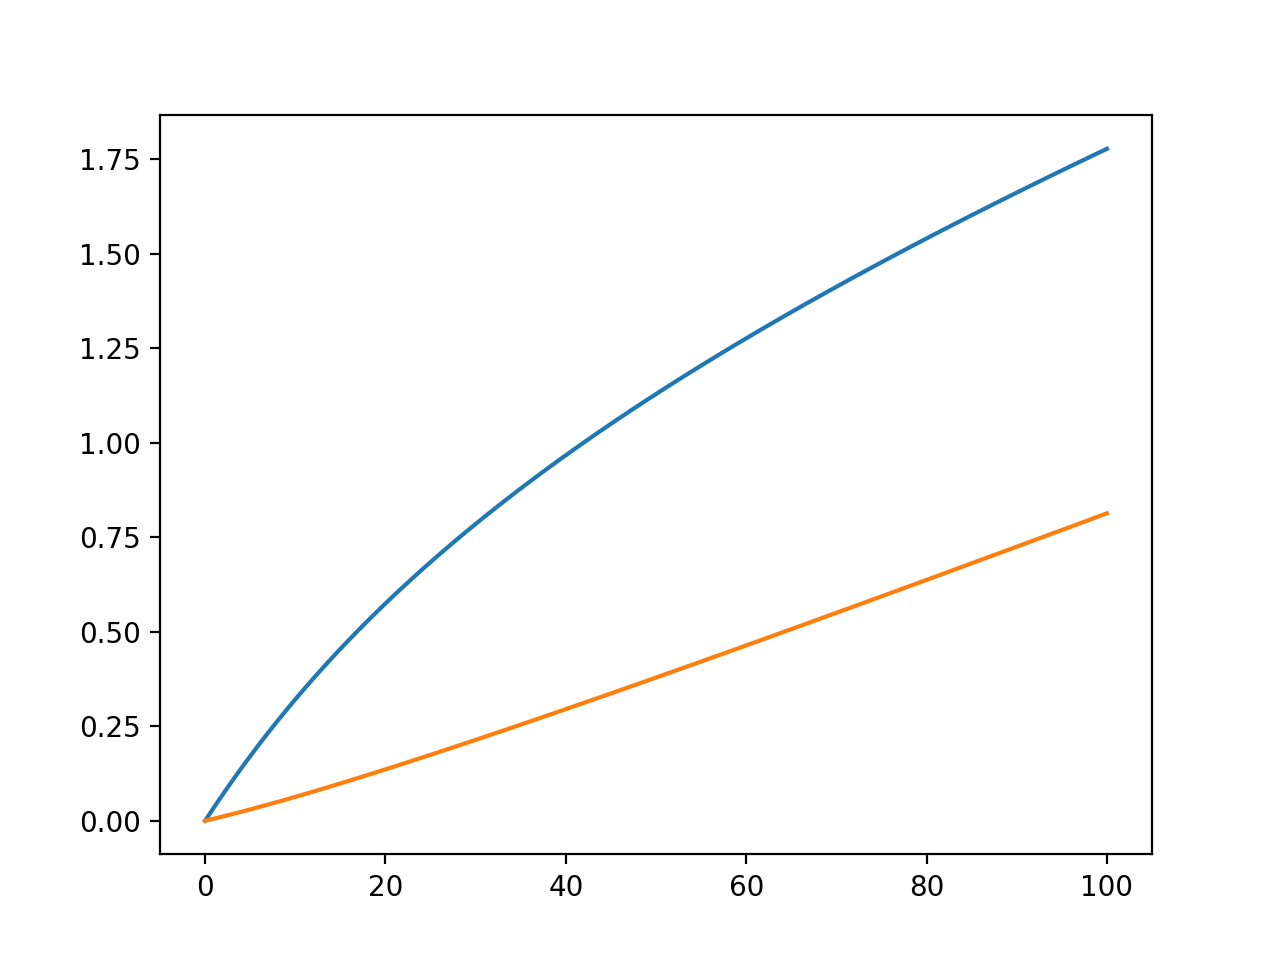

In [131]:
plt.figure()
plt.plot(re)
plt.plot(ri)

In [144]:
def compute_recurrent_soln_nd(B0,W,Wh,h):
    def cost(R):
        return np.sum((R - f_(Wh*h + W@R + B0))**2)
    def costp(R):
        return grad(cost)(R)
    n = B0.shape[0]
    R0 = np.zeros((n,))
    bds = sop.Bounds(lb=np.zeros((n,)),ub=np.inf*np.ones((n,)))
    res = sop.minimize(cost,R0,jac=costp,bounds=bds,method='L-BFGS-B')
    R = res.x
    return R

def compute_recurrent_solns_nd(B0,W,Wh,hmax=1,nh=101):
    nn = B0.shape[0]
    hs = np.linspace(0,hmax,nh)
    R0 = compute_recurrent_soln_nd(B0,W,Wh,hs[0])
    dh = hs[1] - hs[0]
    R = np.zeros((nh,nn))
    R[0] = R0
    for ih,h in enumerate(hs[:-1]):
        X = Wh*h + W@R[ih] + B0
        Phi = np.diag(fp_(X))
        R[ih+1] = R[ih] + dh*np.linalg.pinv(np.eye(nn) - Phi@W)@Phi@Wh
    return R

In [172]:
B = np.array((0,-1,1))
R = compute_recurrent_solns_nd(B,W,np.array((1,0,0)),hmax=5)

<IPython.core.display.Javascript object>


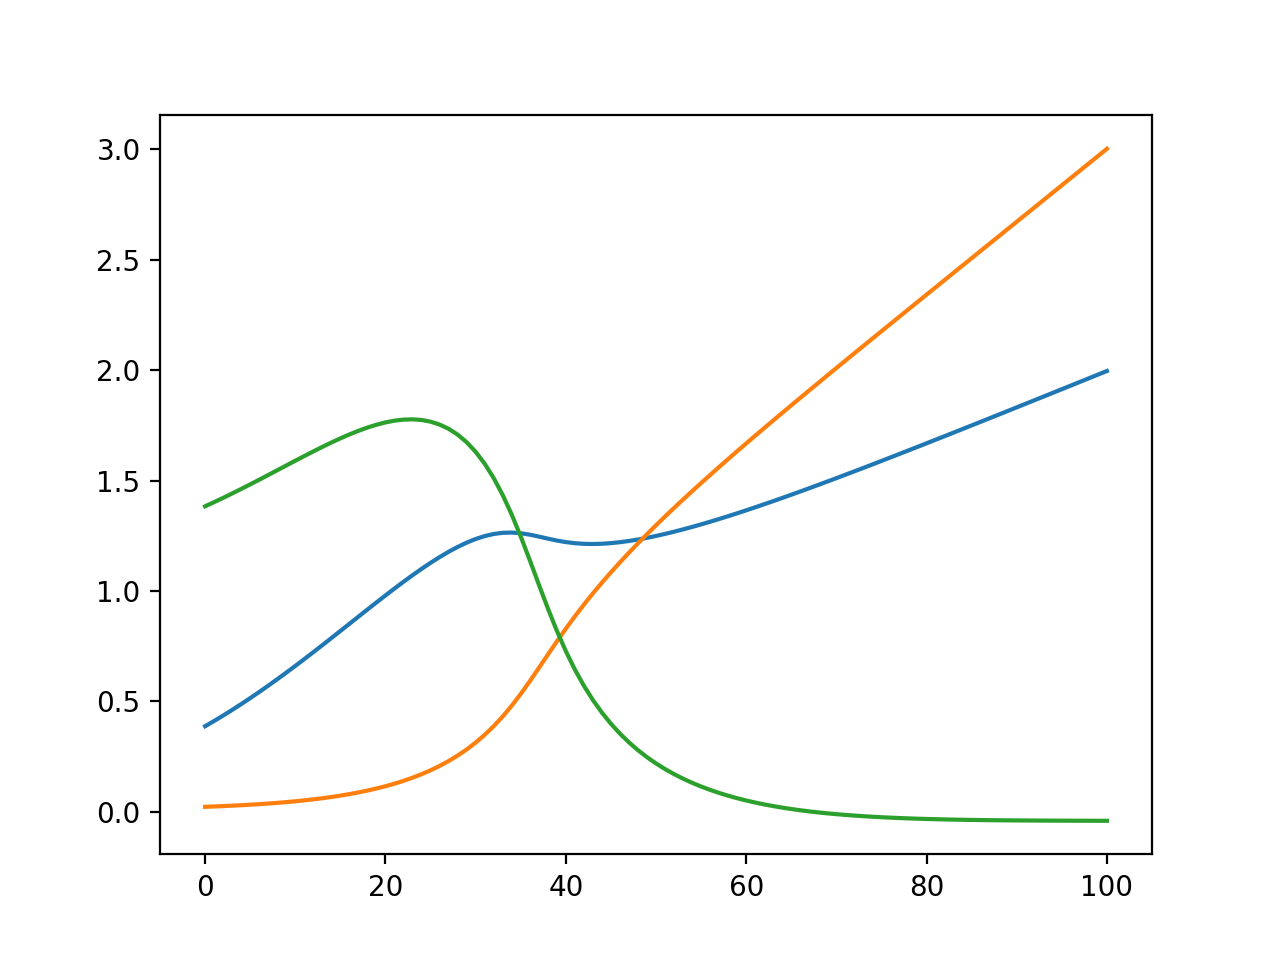

In [173]:
plt.figure()
plt.plot(R+np.arange(3)[np.newaxis,:]*0.0)

<IPython.core.display.Javascript object>


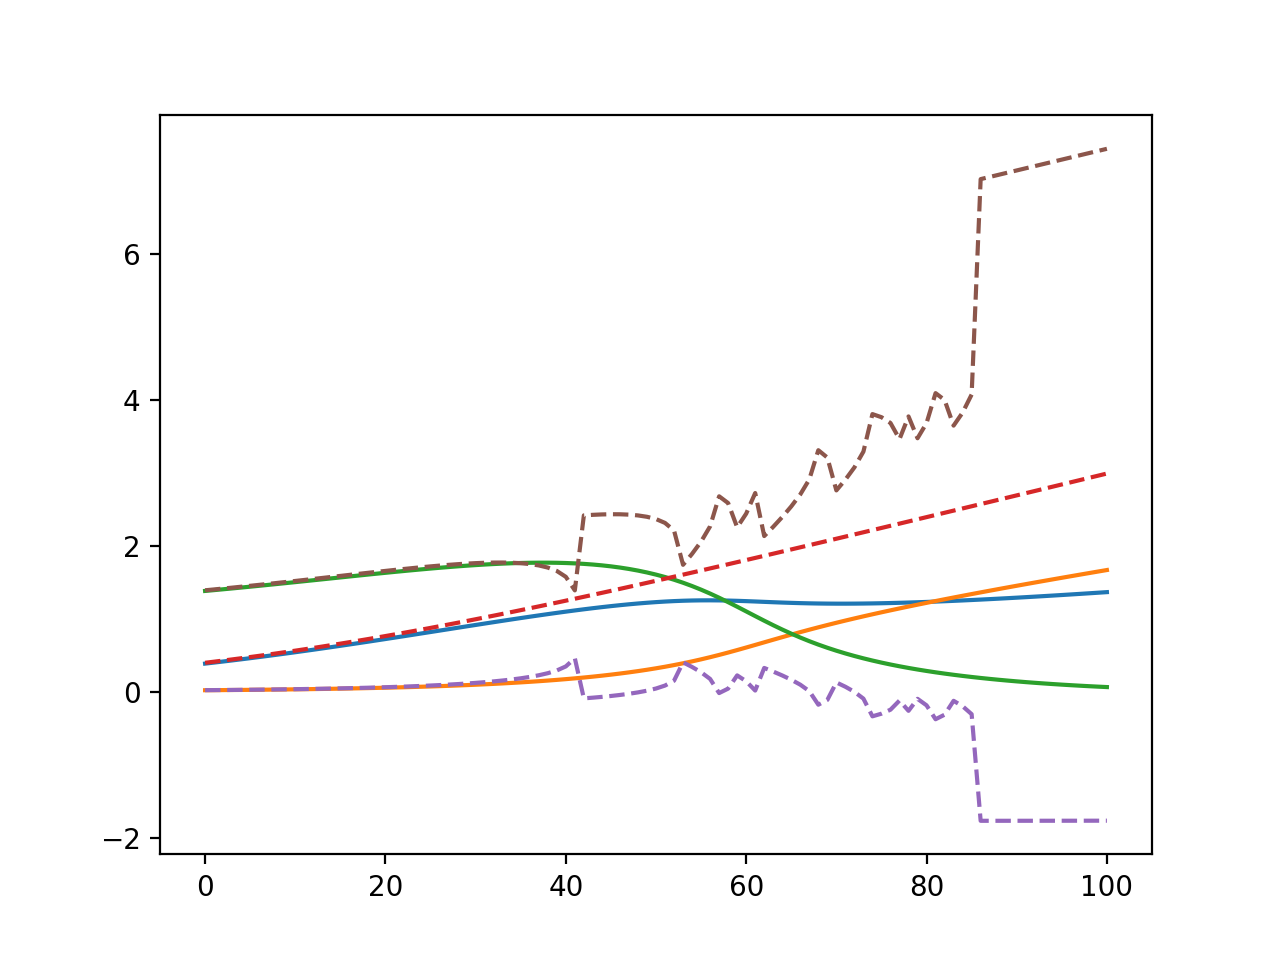

In [189]:
plt.figure()

W = np.array(((0,-1,0),(2,0,-1),(1,-2,0)))
B = np.array((0,-1,1))
Wh = np.array((1,0,0))
R = compute_recurrent_solns_nd(B,W,Wh,hmax=3)
plt.plot(R+np.arange(3)[np.newaxis,:]*0.0)

W = np.array(((0,-1,0),(2,0,-1),(1,-2,0)))
B = np.array((0,-1,-3))
R = compute_recurrent_solns_nd(B,W,Wh,hmax=3)
# plt.plot(R+np.arange(3)[np.newaxis,:]*0.0,linestyle='dashed')

W = np.array(((0,-1*0,0),(2,0,-1),(1,-2,0)))
B = np.array((0,-1,1))
R = compute_recurrent_solns_nd(B,W,Wh,hmax=3)
plt.plot(R+np.arange(3)[np.newaxis,:]*0.0,linestyle='dashed')